In [12]:
%matplotlib inline
import glob
import requests
from datetime import timedelta
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import urllib.request
from bs4 import BeautifulSoup
from astropy import units as u
from astropy.io import fits
from astropy.io import ascii
from astropy.time import Time
from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip
from astropy.table import QTable
from astroquery.jplhorizons import Horizons
from photutils import centroid_com,centroid_sources
from photutils import CircularAperture, aperture_photometry
from photutils.aperture import CircularAperture, CircularAnnulus
from astropy.wcs import utils
from astroquery.jplhorizons import Horizons
import warnings
warnings.filterwarnings('ignore')

In [13]:
cmtname = input("Comet name? ")
date_start = input("Observation start date (format yyyy-mm-dd)? ")
# time_start = input("Observation start time (format hr:min:sec)? ")
date_end = input("Observation end date (format yyyy-mm-dd)? ")
# time_end = input("Obervation end time (format hr:min:sec)? ")
stepsize = input("Stepsize? ")
print('\n')

date_start.replace('-','+')
date_end.replace('-','+')

Comet name? 143p
Observation start date (format yyyy-mm-dd)? 2017-10-09
Observation end date (format yyyy-mm-dd)? 2018-10-24
Stepsize? 1d




'2018+10+24'

In [14]:
website1 = f"https://irsa.ipac.caltech.edu/cgi-bin/MOST/nph-most?catalog=ztf&input_type=name_input&obj_name={cmtname}&obs_begin={date_start}&obs_end={date_end}&output_mode=Full"
website2 = f"https://irsa.ipac.caltech.edu/cgi-bin/MOST/nph-most?catalog=ztf&input_type=name_input&obj_name={cmtname}&obs_begin={date_start}&obs_end={date_end}&output_mode=Brief" 

r = requests.get(website1)
html = r.content

fitses = [] 
filters = ['zr', 'zi'] 
soup = BeautifulSoup(r.content, 'html.parser')

for link in soup.find_all('a'): 
    href = link.get('href') 
    if href.endswith('.fits'): 
        if any(x in href for x in filters): 
            fitses.append(href) 
        else: 
            pass 
    else: 
        continue

In [29]:
def photometry(fitses):
    q = requests.get(website2)

    path = '/Users/josephmurtagh/'
    name = 'response.txt'
    fname = path+name
        
    with open(fname, 'wb') as file:
        file.write(q.content)
        
    data = ascii.read(fname)
    RAguess = []
    DECguess = []
    
    for x in range(len(data)):
        if data[x]['filtercode'] == 'zg':
            pass
        else:
            RAguess.append(data[x]['ra_obj'])
            DECguess.append(data[x]['dec_obj'])

    for i in range(len(fitses)):
        url = fitses[i]
        img = requests.get(url)
        if img.status_code == 404:
            pass
        else:
            path = '/Users/josephmurtagh'
            fname = fitses[i][fitses[i].find('ztf_'):]
        
            with open(fname, 'wb') as file:
                file.write(img.content)
        
#             print(fname)
        
            hdu = fits.open(fname)
            imgdiff = hdu[0].data
            
            hdr = hdu[0].header
            mjd.append(hdr['OBSMJD'])
            dtime = Time(f'{hdr["OBSMJD"]}', format = 'mjd')
            dtime.format = 'iso'
            dtime2 = dtime + timedelta(days=1)
            
            obj = Horizons(id='90001051', location='I41', epochs={'start':dtime.iso, 'stop':dtime2.iso, 'step':'1d'})
            eph = obj.ephemerides(quantities='1,19,20,24')

            delta_au = eph['delta'][0] * u.au
            delta_km = delta_au.to(u.km)
            theta_rad = ((10000*u.km)/(delta_km)) * u.rad
            theta_arcs = theta_rad.to(u.arcsec)
            pix = theta_arcs / hdr['PIXSCALE'] * (1/u.arcsec)
            
            date.append(dtime)
            exptime = hdr['EXPTIME']
            gain = hdr['GAIN']
            rdnoise = hdr['READNOI']
            dark = hdr['DARKCUR']
            zp = hdr['MAGZP']
            wcs = WCS(hdr)
        
            coords = SkyCoord(ra=RAguess[i], dec=DECguess[i], frame='icrs', unit='deg')
            x, y = wcs.world_to_pixel(coords)
        
            xcent, ycent = centroid_sources(imgdiff, x, y, box_size=10, centroid_func=centroid_com)
        
            ap_radii=float(pix)
#             print(ap_radii,ap_radii.dtype)
            pos = (xcent[0],ycent[0])
            aperture = CircularAperture(pos, r=ap_radii)
            annulus_aperture = CircularAnnulus(pos, r_in=2*float(pix), r_out=3*float(pix))
        
            fig = plt.figure()
            ax = plt.subplot(projection = wcs)
            plt.imshow(imgdiff, cmap='gray', norm=ImageNormalize(imgdiff, interval=ZScaleInterval()))
            plt.xlim(int(xcent)-50, int(xcent)+50)
            plt.ylim(int(ycent)-50, int(ycent)+50)
        
            plt.grid(color='w', which='major')
            plt.xlabel('RA')
            plt.ylabel('DEC')
        
            ap_patches = aperture.plot(color='white', lw=2)
            ann_patches = annulus_aperture.plot(color='red', lw=2)
            annulus_mask = annulus_aperture.to_mask(method='center')
        
            phot = aperture_photometry(imgdiff, aperture)
        
            annulus_data = annulus_mask.multiply(imgdiff)
            annulus_data_1d = annulus_data[annulus_mask.data > 0]
            _, bkg_median, _ = sigma_clipped_stats(annulus_data_1d)
            phot['sky_bkg'] = bkg_median
            
            phot['aper_sky'] = bkg_median * aperture.area
            phot['counts_minus_sky'] = phot['aperture_sum'] - phot['aper_sky'] 
            n_target=phot['counts_minus_sky']
            n_sky=phot['aper_sky']
            n_dark=dark*exptime
            err_electrons=np.sqrt(gain*n_target + gain*n_sky + n_dark*aperture.area + rdnoise*rdnoise*aperture.area)
            err_adus=err_electrons/gain
            phot['uncertainty'] = err_adus
        
            for col in phot.colnames:
                phot[col].info.format='%.2f'
        
            m = -2.5 * np.log10(phot['counts_minus_sky']) + zp
            mag.append(m[0])
            filters.append(hdr['FILTER'])
            
            plt.title(f'{dtime}')
            plt.legend([ap_patches],[f'Mag: {m[0]:.4}  Filter: {hdr["FILTER"]}'])
            plt.show()
            
            if hdr['FILTER'] == 'ZTF r':
                afrho_r.append(((10**(-0.4 * (m[0] - Msun_r))) *(4 * eph['r'][0]**2 * delta_km**2 )/(10000 * u.km)).to(u.cm))
            else:
                afrho_i.append(((10**(-0.4 * (m[0] - Msun_i))) *(4 * eph['r'][0]**2 * delta_km**2 )/(10000 * u.km)).to(u.cm))

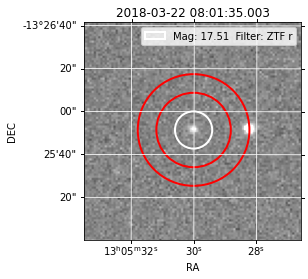

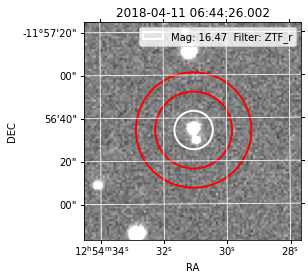

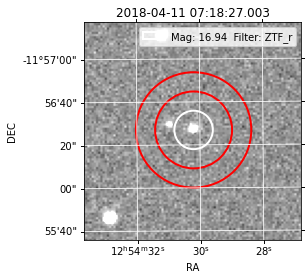

KeyboardInterrupt: 

In [31]:
Msun_r = -26.93
Msun_i = -27.05
afrho_r = []
afrho_i = []
mag = []
filters = []
date = []
mjd = []
photometry(fitses)
mags = QTable([mag, filters, date, mjd], names=['Magnitude', 'Filter', 'Date','MJD'])
print(mags)

<function matplotlib.pyplot.show(close=None, block=None)>

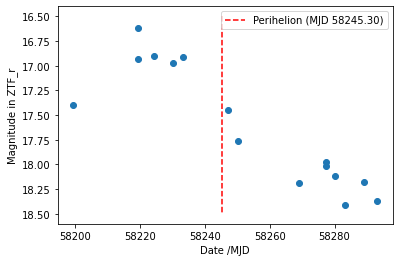

In [36]:
plt.scatter(mags['MJD'], mags['Magnitude'])
plt.gca().invert_yaxis()
perihelion_jd = 2458245.80250
perihelion_mjd = perihelion_jd - 2400000.5
peri = plt.vlines(perihelion_mjd, ymin=16.5, ymax=18.5, linestyle='dashed', color='r', label = f'Perihelion (MJD {perihelion_mjd:.2f})')
plt.xlabel('Date /MJD')
plt.ylabel('Magnitude in ZTF_r')
plt.legend()
plt.show

In [4]:
from astropy import units as u
scale = 1.05 * (u.arcsec)
# pixel = u.pixel_scale(scale)

In [15]:
print(pixel)

[(Unit("pix"), Unit("1.05 arcsec"))]


In [28]:
delta = 1.59192529858938 * u.au
delta_km = delta.to(u.km)
angle = 2.4240684e-5
dist = angle * delta_km
print(dist)

5772.885805640502 km


In [6]:
scale_rad = 5 * scale.to(u.rad)
print(scale_rad)

2.545271825825064e-05 rad
